In [1]:
## PROJECT: FLO | CLV Prediction with BG-NBD and Gamma-Gamma Model (Customer Lifetime Value Prediction) ##

In [2]:
# Customer Lifetime Value is the monetary value that a customer will bring to a company during their relationship with that company.

# Probabilistic CLV Prediction with time projection is a type of analysis that estimates the income that a customer will provide to a company.
# This method tries to predict the future purchase probability of the customer by using their past behaviour and purchasing habits.
# It helps companies manage their relationships with their customers and support their marketing strategies.

# CLV prediction = BG/NBD Model x Gamma-Gamma Model
# CLV prediction = Expected Total Transaction x Expected Average Profit (Expected number of purchases x Expected average profit))

# We estimate the CLV value for each customer. Using probability distributions, we model the behaviour of our general audience and reduce them to the specifics of individuals.

## BG/NBD Model: Used to estimate the expected number of purchases a customer will make. (Expected Total Transaction)
## Gamma-Gamma Model: Used to estimate the expected average profit of a customer. (Expected average profit)

# Recency: Customer last purchase date - Customer first purchase date
# Frequency: Total number of transactions (number of invoices)
# Monetory: Average spending amount
# Customer Age (T): Analysis date - Customer first purchase date

In [3]:
## PROJECT STEPS ##
# 1. Business Problem
# 2. Required Library and Functions
# 3. Understanding the Data
# 4. Data Preparation
# 5. Creating the CLV Data Structure (Preparation of Metrics)
# 6. Expected Number of Transactions with BG-NBD Model
# 7. Expected Average Profit with Gamma-Gamma Model
# 8. Calculating CLV with BG-NBD and Gamma-Gamma Model
# 9. Creating Segments According to CLV
# 10. Functionalization of the Study

In [4]:
# 1. Business Problem 

# FLO, one of the leading companies in the Turkish shoe market, 
# wants the revenue that its customers will provide to the company to be estimated and divided into segments according to these CLV values.

# The dataset, which contains information about approximately 20,000 customers, 
# consists of information obtained from the past shopping behaviours of customers who made their last purchases as OmniChannel (both online and offline shopping) in 2020-2021.

In [5]:
## Variables ##

# master_id: Unique customer number
# order_channel: Which channel of the shopping platform is used (Android, ios, Desktop, Mobile, Offline)
# last_order_channel: Channel where the last shopping was made
# first_order_date: Date of the customer's first shopping
# last_order_date: Date of the customer's last shopping
# last_order_date_online: Date of the customer's last shopping on the online platform
# last_order_date_offline: Date of the customer's last shopping on the offline platform
# order_num_total_ever_online: Total number of shopping made by the customer on the online platform
# order_num_total_ever_offline: Total number of shopping made by the customer offline
# customer_value_total_ever_offline: Total fee paid by the customer for offline shopping
# customer_value_total_ever_online: Total fee paid by the customer for online shopping
# customer_value_total_ever_online: Total fee paid by the customer for online shopping
# interested_in_categories_12: List of categories the customer has shopped in the last 12 months

In [6]:
# 2. Required Libraries and Functions

# pip install lifetimes

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)    # all columns
pd.set_option("display.width", 500)           # all columns "side by side"
pd.set_option("display.precision", 4)         # float numbers have 4 digits after the decimal point

from sklearn.preprocessing import MinMaxScaler

In [7]:
# This function calculates the lower and upper limits for outliers for a given variable (the outlier value)

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)      # Calculates the lower 1% quartile (1st percentile) of the specified variable in the dataset.
    quartile3 = dataframe[variable].quantile(0.99)      # Calculates the upper 99% quartile (99th percentile) of the specified variable in the dataset.
    interquantile_range = quartile3 - quartile1         # Calculates the interquartile range.
    up_limit = quartile3 + 1.5 * interquantile_range    # Calculates the upper limits.
    low_limit = quartile1 - 1.5 * interquantile_range   # Calculates the lower limits.
    return low_limit, up_limit                          # Returns the calculated lower and upper limits.

In [8]:
# This function is used to replace the outliers of a given variable with the specified lower and upper limits.
# Note: When calculating CLV, frequency values ​​must be integer. Therefore, round the lower and upper limits with round().

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable) # Gets the lower and upper limits for the given variable from the outlier_thresholds function.
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,0) # If you want to set the outliers equal to the lower limit, you need to remove the comment line and enable this line.
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0) # Set the outliers equal to the upper limit.

In [10]:
# 3. Understanding the Data

# Read from CSV
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()

In [12]:
# Exploratory Data Analysis Function : Displays basic characteristics of the DataFrame.

def check_df(dataframe, head=5):
    print("__________________________________________________________________ FIRST 5 ROWS __________________________________________________________________ ")
    print(dataframe.head(head))
    print("__________________________________________________________________  LAST 5 ROWS __________________________________________________________________ ")
    print(dataframe.tail(head))
    print("__________________________________________________________________  DATA SHAPE ___________________________________________________________________ ")
    print(dataframe.shape)
    print("_________________________________________________________________  GENERAL INFO __________________________________________________________________ ")
    print(dataframe.info())
    print("__________________________________________________________________  NULL VALUES __________________________________________________________________ ")
    print(dataframe.isnull().sum().sort_values(ascending=False))
    print("_______________________________________________________________  DUPLICATED VALUES _______________________________________________________________ ")
    print(dataframe.duplicated().sum())
    print("____________________________________________________________________ DESCRIBE ____________________________________________________________________ ")
    print(dataframe.describe([0, 0.05, 0.1, 0.25, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

__________________________________________________________________ FIRST 5 ROWS __________________________________________________________________ 
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online       interested_in_categories_12
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline       2020-10-30      2021-02-26             2021-02-21              2021-02-26                          4.0                           1.0                             139.99                            799.38                           [KADIN]
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile       2017-02-08      2021-02-16             2021-02-16              2020-01-10                         19.0                           2.0           

In [ ]:
# 4. Data Preparation

In [14]:
# There are no NaN values, if there were we would delete or fill the rows that contain them.

df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [16]:
# Min shopping counts and spending amounts should be >= 1

df.describe()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online
count,19945.0000,19945.0000,19945.0000,19945.0000
mean,3.1109,1.9139,253.9226,497.3217
std,4.2256,2.0629,301.5329,832.6019
min,1.0000,1.0000,10.0000,12.9900
25%,1.0000,1.0000,99.9900,149.9800
50%,2.0000,1.0000,179.9800,286.4600
75%,4.0000,2.0000,319.9700,578.4400
max,200.0000,109.0000,18119.1400,45220.1300


In [19]:
# Converting the type of variables representing dates to "date Dtype"

df.dtypes
df["first_order_date"] = pd.to_datetime(df["first_order_date"])
df["last_order_date"] = pd.to_datetime(df["last_order_date"])
df["last_order_date_online"] = pd.to_datetime(df["last_order_date_online"])
df["last_order_date_offline"] = pd.to_datetime(df["last_order_date_offline"])

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
dtype: object

In [20]:
# Creating new variables for each customer's total number of purchases and spending.

df["total_order_number"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["total_customer_value"] = df["customer_value_total_ever_online"] + df["customer_value_total_ever_offline"]

In [21]:
# hanging the master_id column name to customer_id 

df = df.rename(columns={"master_id": "customer_id"})

In [22]:
# Suppressing the outliers in the variables

replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

In [23]:
df.describe()

,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,total_order_number,total_customer_value
count,19945,19945,19945,19945,19945.0000,19945.0000,19945.0000,19945.0000,19945.0000,19945.0000
mean,2019-03-22 16:43:55.246929152,2021-01-17 12:59:57.653547264,2020-08-10 01:08:52.644773376,2020-05-17 12:07:24.021058048,3.0920,1.8862,251.9213,489.7057,5.0248,751.2443
min,2013-01-14 00:00:00,2020-05-30 00:00:00,2014-02-24 00:00:00,2019-01-22 00:00:00,1.0000,1.0000,10.0000,12.9900,2.0000,44.9800
25%,2019-02-16 00:00:00,2020-11-11 00:00:00,2020-06-18 00:00:00,2019-11-04 00:00:00,1.0000,1.0000,99.9900,149.9800,3.0000,339.9800
50%,2019-08-20 00:00:00,2021-02-10 00:00:00,2020-12-14 00:00:00,2020-06-22 00:00:00,2.0000,1.0000,179.9800,286.4600,4.0000,545.2700
75%,2020-01-01 00:00:00,2021-04-19 00:00:00,2021-04-05 00:00:00,2020-12-25 00:00:00,4.0000,2.0000,319.9700,578.4400,6.0000,897.7800
max,2021-05-27 00:00:00,2021-05-30 00:00:00,2021-05-30 00:00:00,2021-05-28 00:00:00,48.0000,16.0000,3020.0000,7800.0000,202.0000,45905.1000
std,NaN,NaN,NaN,NaN,3.8095,1.4347,251.0237,632.6098,4.7427,895.4022


In [ ]:
# 5. Creating the CLV Data Structure (Preparation of Metrics)

In [24]:
# Defining the day the analysis was performed. If the last purchase date in the data frame is May 30, 2021:

df["last_order_date"].max()    # last purchase date in the data frame

today_date = dt.datetime(2021, 6, 1)

In [25]:
# Adding recency, frequency, monetary, T columns to the original data frame.

df["recency"] = (df["last_order_date"] - df["first_order_date"]).dt.days
df["frequency"] = df["total_order_number"]
df["monetary"] = df["total_customer_value"] / df["total_order_number"]  
df["T"] = (today_date - pd.to_datetime(df["first_order_date"])).dt.days

In [26]:
# Recency and Customer Age (T) values ​​should be weekly, converting it to weekly: by dividing by 7

df["recency"] = df["recency"] / 7
df["T"] = df["T"] / 7

In [27]:
# Creating a new data frame named clv_df and adding the relevant 4 columns.

clv_df = df.loc[:, ["customer_id", "recency", "frequency", "monetary", "T"]]

In [28]:
clv_df.describe().T

# Frequency must be >1! and data frame shows min 2. If it wasn't >1, we would have to say: clv_df = clv_df[(clv_df['frequency'] > 1)]

,count,mean,std,min,25%,50%,75%,max
recency,19945.0,95.2635,74.5894,0.0000,50.4286,76.5714,109.4286,433.4286
frequency,19945.0,5.0248,4.7427,2.0000,3.0000,4.0000,6.0000,202.0000
monetary,19945.0,152.3994,83.5039,22.4900,103.4900,136.7350,182.4450,5176.5850
T,19945.0,114.4718,74.7710,0.7143,73.8571,93.0000,119.4286,437.1429


In [30]:
clv_df.dtypes # Frequency was not an integer and we should convert it to an integer.

# Frequency should be an integer, so converting it to an integer.

clv_df["frequency"] = clv_df["frequency"].astype(int)
clv_df.dtypes

customer_id     object
recency        float64
frequency        int32
monetary       float64
T              float64
dtype: object

In [32]:
# Reassigning customer_id as index

clv_df.set_index('customer_id', inplace=True)

In [35]:
clv_df.describe().T
clv_df.head()

,recency,frequency,monetary,T
customer_id,,,,
cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,5,187.8740,30.5714
f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,21,95.8833,224.8571
69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,5,117.0640,78.8571
1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,2,60.9850,20.8571
d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,2,104.9900,95.4286


In [36]:
# Updating the column names:
# Creating a clv data frame containing "customer_id", "recency_clv_weekly", "T_weekly", "frequency" and "monetary_clv_avg" values.)

clv_df.rename(columns={"T": "T_weekly", "recency": "recency_clv_weekly", "monetary": "monetary_clv_avg"}, inplace=True)

In [ ]:
# 6. Setting up the BG-NBD Model

# This model estimates the expected number of purchases a customer will make. (Expected Total Transaction)

In [37]:
# Penalty coefficient to be applied to the coefficients: 0.001

bgf = BetaGeoFitter(penalizer_coef=0.001)

In [38]:
bgf.fit(clv_df['frequency'],
        clv_df['recency_clv_weekly'],
        clv_df['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 71.57, b: 0.26, r: 3.48>

In [ ]:
# Weekly Purchase Count Results

In [40]:
# Top 10 customers with the highest expected purchases in 1 week: (t:1, meaning make a 1-week forecast)

bgf.predict(1,
            clv_df['frequency'],
            clv_df['recency_clv_weekly'],
            clv_df['T_weekly']).sort_values(ascending=False).head(10)

customer_id
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f    0.5292
329968c6-a0e2-11e9-a2fc-000d3a38a36f    0.4521
5d1c466a-9cfd-11e9-9897-000d3a38a36f    0.4371
44d032ee-a0d4-11e9-a2fc-000d3a38a36f    0.4196
03f502d4-a559-11e9-a2fc-000d3a38a36f    0.3388
d5ef8058-a5c6-11e9-a2fc-000d3a38a36f    0.3268
4a51668a-a155-11e9-a2fc-000d3a38a36f    0.3196
4a7e875e-e6ce-11ea-8f44-000d3a38a36f    0.2911
695889b4-d6ed-11e9-93bc-000d3a38a36f    0.2877
1902bf80-0035-11eb-8341-000d3a38a36f    0.2716
dtype: float64

In [41]:
# Expected number of purchases in 1 week for all customers

clv_df["expected_purc_1_week"] = bgf.predict(1,
                                              clv_df['frequency'],
                                              clv_df['recency_clv_weekly'],
                                              clv_df['T_weekly'])

In [ ]:
# Quarterly Purchase Count Results

In [42]:
# Number of expected purchases in 3 months for all customers

clv_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                           clv_df['frequency'],
                                           clv_df['recency_clv_weekly'],
                                           clv_df['T_weekly']).sort_values(ascending=False)

In [43]:
# Researching the 10 customers who will make the most purchases in 3 months.

clv_df.sort_values(by="exp_sales_3_month", ascending=False).head(10)

,recency_clv_weekly,frequency,monetary_clv_avg,T_weekly,expected_purc_1_week,exp_sales_3_month
customer_id,,,,,,
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,70,263.4796,67.2857,0.5292,6.3500
329968c6-a0e2-11e9-a2fc-000d3a38a36f,111.5714,83,51.0887,119.7143,0.4521,5.4250
5d1c466a-9cfd-11e9-9897-000d3a38a36f,394.0000,202,227.2530,398.5714,0.4371,5.2447
44d032ee-a0d4-11e9-a2fc-000d3a38a36f,104.4286,77,67.3253,120.1429,0.4196,5.0352
03f502d4-a559-11e9-a2fc-000d3a38a36f,104.7143,61,45.2208,118.7143,0.3388,4.0659
d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,68,541.4454,147.1429,0.3268,3.9215
4a51668a-a155-11e9-a2fc-000d3a38a36f,87.1429,51,86.1541,98.8571,0.3196,3.8357
4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,29,165.2976,40.0000,0.2911,3.4932
695889b4-d6ed-11e9-93bc-000d3a38a36f,91.8571,47,175.4581,103.8571,0.2877,3.4528


In [44]:
# Expected Sales Number of the Entire Company in 3 Months

bgf.predict(4 * 3,
            clv_df['frequency'],
            clv_df['recency_clv_weekly'],
            clv_df['T_weekly']).sum()

11608.948167571793

In [ ]:
# Estimating the expected purchases from customers in 6 months and adding it to the CLV data frame as exp_sales_6_month.

In [45]:
# Number of expected purchases for all customers within 24 weeks (4 weeks x 6)

clv_df["exp_sales_6_month"] = bgf.predict(4  * 6,
                                           clv_df['frequency'],
                                           clv_df['recency_clv_weekly'],
                                           clv_df['T_weekly']).sort_values(ascending=False)

In [47]:
# Researching the 10 people who will shop the most in 6 months.

clv_df.sort_values(by="exp_sales_6_month", ascending=False).head(10)

,recency_clv_weekly,frequency,monetary_clv_avg,T_weekly,expected_purc_1_week,exp_sales_3_month,exp_sales_6_month
customer_id,,,,,,,
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,70,263.4796,67.2857,0.5292,6.3500,12.6999
329968c6-a0e2-11e9-a2fc-000d3a38a36f,111.5714,83,51.0887,119.7143,0.4521,5.4250,10.8500
5d1c466a-9cfd-11e9-9897-000d3a38a36f,394.0000,202,227.2530,398.5714,0.4371,5.2447,10.4893
44d032ee-a0d4-11e9-a2fc-000d3a38a36f,104.4286,77,67.3253,120.1429,0.4196,5.0352,10.0703
03f502d4-a559-11e9-a2fc-000d3a38a36f,104.7143,61,45.2208,118.7143,0.3388,4.0659,8.1317
d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,68,541.4454,147.1429,0.3268,3.9215,7.8430
4a51668a-a155-11e9-a2fc-000d3a38a36f,87.1429,51,86.1541,98.8571,0.3196,3.8357,7.6714
4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,29,165.2976,40.0000,0.2911,3.4932,6.9863
695889b4-d6ed-11e9-93bc-000d3a38a36f,91.8571,47,175.4581,103.8571,0.2877,3.4528,6.9056


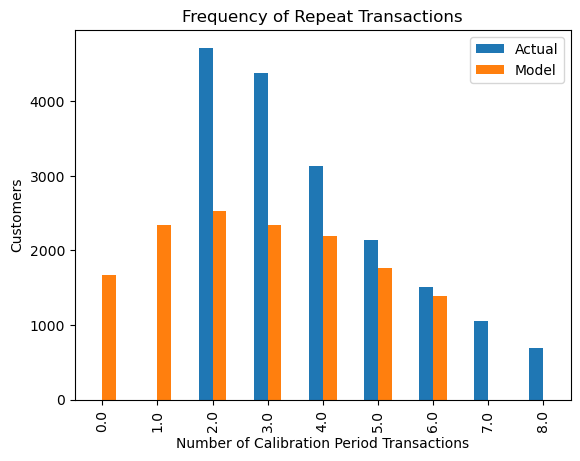

In [48]:
# Comparison graph for actual and model values

plot_period_transactions(bgf)
plt.show()

In [ ]:
# 7. Setting up the GAMMA-GAMMA Model

# GAMMA-GAMMA model is used to estimate the expected average profit of a customer.

In [49]:
# Penalty coefficient to be applied to the coefficients: 0.001

ggf = GammaGammaFitter(penalizer_coef=0.01)

In [50]:
ggf.fit(clv_df['frequency'],
        clv_df['monetary_clv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [51]:
# Estimating the average value/profit that customers will leave (Expected Average Profit) and adding it to the clv data frame as exp_average_value.

clv_df["exp_average_value"] = ggf.conditional_expected_average_profit(clv_df['frequency'],
                                                                       clv_df['monetary_clv_avg'])

In [52]:
# Expected Average Profit for the first 10 Customers

clv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(clv_df['frequency'],
                                        clv_df['monetary_clv_avg'])

clv_df.sort_values(by="expected_average_profit", ascending=False).head(10)

,recency_clv_weekly,frequency,monetary_clv_avg,T_weekly,expected_purc_1_week,exp_sales_3_month,exp_sales_6_month,exp_average_value,expected_average_profit
customer_id,,,,,,,,,
47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,4,5176.5850,7.8571,0.0941,1.1297,2.2595,5348.2785,5348.2785
7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,11,2838.8555,13.1429,0.1709,2.0508,4.1017,2872.5603,2872.5603
f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,7,1106.4671,101.0000,0.0607,0.7285,1.4569,1127.6121,1127.6121
9083981a-f59e-11e9-841e-000d3a38a36f,63.5714,4,1090.3600,83.8571,0.0481,0.5773,1.1546,1127.3554,1127.3554
851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,2,862.6900,9.4286,0.0676,0.8115,1.6230,923.6815,923.6815
6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57.0000,2,859.5800,94.8571,0.0329,0.3949,0.7899,920.3595,920.3595
f02473b0-43c3-11eb-806e-000d3a38a36f,17.2857,2,835.8750,23.1429,0.0578,0.6940,1.3880,895.0384,895.0384
ae4ce104-dbd4-11ea-8757-000d3a38a36f,3.7143,3,844.3467,42.0000,0.0570,0.6843,1.3686,883.2890,883.2890
3a27b334-dff4-11ea-acaa-000d3a38a36f,40.0000,3,837.0567,41.1429,0.0575,0.6897,1.3793,875.6751,875.6751


In [ ]:
# 8. Calculating 6-month CLV with BG-NBD and GAMMA-GAMMA model

In [53]:
# Calculating 6-month CLV with the ggf model and bgf model we set up before and adding it to the data frame with the name clv.

clv_df["clv"] = ggf.customer_lifetime_value(bgf,
                                   clv_df['frequency'],
                                   clv_df['recency_clv_weekly'],
                                   clv_df['T_weekly'],
                                   clv_df['monetary_clv_avg'],
                                   time=6,    
                                   freq="W",  
                                   discount_rate=0.01)

In [54]:
clv_df.head()

,recency_clv_weekly,frequency,monetary_clv_avg,T_weekly,expected_purc_1_week,exp_sales_3_month,exp_sales_6_month,exp_average_value,expected_average_profit,clv
customer_id,,,,,,,,,,
cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,5,187.8740,30.5714,0.0830,0.9960,1.9920,193.6328,193.6328,404.6941
f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,21,95.8833,224.8571,0.0826,0.9909,1.9818,96.6651,96.6651,201.0020
69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,5,117.0640,78.8571,0.0564,0.6763,1.3525,120.9677,120.9677,171.6671
1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,2,60.9850,20.8571,0.0593,0.7111,1.4222,67.3201,67.3201,100.4584
d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,2,104.9900,95.4286,0.0328,0.3936,0.7872,114.3252,114.3252,94.4271


In [55]:
# Changing the Customer ID from index to variable

clv_df = clv_df.reset_index()

In [ ]:
# 9. Creating Segments According to CLV

In [58]:
# According to 6-month CLV, dividing all customers into 4 groups (segments) and adding the group names to the data set. 
# Assigning it with the name clv_segment

clv_df["clv_segment"] = pd.qcut(clv_df["clv"], 4, labels=["D", "C", "B", "A"])
clv_df.sort_values(by = "clv", ascending = False).head(50)

,customer_id,recency_clv_weekly,frequency,monetary_clv_avg,T_weekly,expected_purc_1_week,exp_sales_3_month,exp_sales_6_month,exp_average_value,expected_average_profit,clv,clv_segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,4,5176.5850,7.8571,0.0941,1.1297,2.2595,5348.2785,5348.2785,12679.1281,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,11,2838.8555,13.1429,0.1709,2.0508,4.1017,2872.5603,2872.5603,12362.1890,A
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,68,541.4454,147.1429,0.3268,3.9215,7.8430,542.5238,542.5238,4464.4582,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,70,263.4796,67.2857,0.5292,6.3500,12.6999,264.0193,264.0193,3518.0635,A
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,394.0000,202,227.2530,398.5714,0.4371,5.2447,10.4893,227.4169,227.4169,2502.8638,A
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,16,622.0819,74.5714,0.1333,1.5994,3.1987,627.3416,627.3416,2105.4665,A
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,383.0000,82,413.6354,385.0000,0.1872,2.2466,4.4932,414.3301,414.3301,1953.3091,A
18767,fc0ce7a4-9d87-11e9-9897-000d3a38a36f,102.5714,20,605.1575,131.4286,0.1156,1.3878,2.7755,609.2498,609.2498,1774.2302,A
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,7,1106.4671,101.0000,0.0607,0.7285,1.4569,1127.6121,1127.6121,1723.7007,A
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,8,601.2262,34.4286,0.1083,1.2991,2.5981,611.4929,611.4929,1666.9326,A


In [59]:
# Examining the Recency, Frequency and Monetary averages of the segments

clv_df.groupby("clv_segment").agg({"recency_clv_weekly": ["mean"], "frequency": ["mean"], "monetary_clv_avg": ["mean"]})

,recency_clv_weekly,frequency,monetary_clv_avg
,mean,mean,mean
clv_segment,,,
D,139.3576,3.8023,93.4656
C,92.6934,4.4049,126.0968
B,81.7196,5.0886,160.4783
A,67.2745,6.8034,229.5689


In [60]:
# 6 Month CLV Values for all customers

clv_df.sort_values(by="clv", ascending=False)

,customer_id,recency_clv_weekly,frequency,monetary_clv_avg,T_weekly,expected_purc_1_week,exp_sales_3_month,exp_sales_6_month,exp_average_value,expected_average_profit,clv,clv_segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,4,5176.5850,7.8571,9.4146e-02,1.1297,2.2595,5348.2785,5348.2785,12679.1281,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,11,2838.8555,13.1429,1.7090e-01,2.0508,4.1017,2872.5603,2872.5603,12362.1890,A
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,68,541.4454,147.1429,3.2679e-01,3.9215,7.8430,542.5238,542.5238,4464.4582,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,70,263.4796,67.2857,5.2916e-01,6.3500,12.6999,264.0193,264.0193,3518.0635,A
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,394.0000,202,227.2530,398.5714,4.3705e-01,5.2447,10.4893,227.4169,227.4169,2502.8638,A
...,...,...,...,...,...,...,...,...,...,...,...,...
11232,f486e45e-a691-11e9-a2fc-000d3a38a36f,350.5714,2,45.2400,378.1429,1.2180e-02,0.1462,0.2923,50.5017,50.5017,15.4896,D
27,c1f8f878-9f35-11e9-9897-000d3a38a36f,404.0000,4,32.7175,417.1429,1.5301e-02,0.1836,0.3672,34.8488,34.8488,13.4271,D
1710,08b95b62-a987-11e9-a2fc-000d3a38a36f,226.5714,2,22.4900,232.4286,1.8019e-02,0.2162,0.4324,26.2007,26.2007,11.8882,D
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,65.0000,111,93.5445,94.8571,3.2151e-04,0.0039,0.0077,93.6890,93.6890,0.7585,D


In [61]:
# 50 customers with the highest 6-month CLV values

clv_df.sort_values(by="clv", ascending=False).head(50)

clv_df.loc[:, ['customer_id', 'recency_clv_weekly', 'frequency', 'monetary_clv_avg', 'clv', 'clv_segment']].sort_values(by='clv', ascending=False).head(50)

,customer_id,recency_clv_weekly,frequency,monetary_clv_avg,clv,clv_segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,4,5176.5850,12679.1281,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,11,2838.8555,12362.1890,A
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,68,541.4454,4464.4582,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,70,263.4796,3518.0635,A
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,394.0000,202,227.2530,2502.8638,A
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,16,622.0819,2105.4665,A
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,383.0000,82,413.6354,1953.3091,A
18767,fc0ce7a4-9d87-11e9-9897-000d3a38a36f,102.5714,20,605.1575,1774.2302,A
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,7,1106.4671,1723.7007,A
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,8,601.2262,1666.9326,A


In [62]:
# To examine the first 50 customers, calling the order_channel and interested_in_categories_12 columns from the first data frame

six_months_max_clv_customers = pd.merge(clv_df, df[["customer_id","order_channel", "interested_in_categories_12"]], how="inner", on="customer_id")
six_months_max_clv_customers.sort_values(by="clv", ascending=False).head(50)


six_months_max_clv_customers.groupby("clv_segment").agg({"exp_sales_6_month": ["sum"],
                                                           "clv": ["sum"]})

,exp_sales_6_month,clv
,sum,sum
clv_segment,,
D,4052.8568,3.9899e+05
C,5243.2318,6.9051e+05
B,6032.8858,9.9925e+05
A,7888.8669,1.8574e+06


In [ ]:
# Action Recommendations to the Management within the Scope of CLV Values

In [ ]:
## Segment A (CLV 1,857,360 for 6 months - Expected Sales Units 7,889):

# These customers can be rewarded as "loyal customers" with the highest CLV values ​​by offering them Special Discounts, Personalized Mail/SMS, and Loyalty Programs and increasing their future sales.
# Management can increase the purchase quantities and CLV values ​​of these customers who already have high and regular purchases by applying cross-selling and up-selling strategies.
# Management can increase customer satisfaction by offering premium services such as fast delivery options and a limited number of products.
# Management can increase customer interest in the brand and increase sales by organizing VIP customer programs or special events.

In [ ]:
## Segment B (CLV 999,253 for 6 months - Expected Sales Units 6,033):

# Management can apply cross-selling and up-selling strategies to increase the purchase quantities and CLV values ​​of "potential loyal customers" in this segment. Thus, you can increase the CLV value of the segment.
# By organizing VIP customer programs or special events, management can increase customer interest in the brand and increase sales.

In [ ]:
## C Segment (CLV 690,508 for 6 months - Expected Sales Units 5,243):

# By focusing on the "customers with the highest CLV" in this segment, management can encourage these customers with campaigns and special discounts, increase the CLV value of the segment and enable them to move up to the B segment.

In [ ]:
## Segment D (CLV 398,991 for 6 months - Expected Sales 4,053):

# By offering low-cost products or services to frequent shoppers in this segment, management can encourage them to shop more frequently and move them up to segment C.
# By regularly receiving feedback from customers in this segment, management can look for opportunities to improve your products and services.

In [ ]:
# 10. Functionalization of the Study

In [ ]:
def create_clv_df(dataframe):

    # Preparing the Data
    columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
    for col in columns:
        replace_with_thresholds(dataframe, col)

    dataframe["order_num_total"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]
    dataframe["customer_value_total"] = dataframe["customer_value_total_ever_offline"] + dataframe["customer_value_total_ever_online"]
    dataframe = dataframe[~(dataframe["customer_value_total"] == 0) | (dataframe["order_num_total"] == 0)]
    date_columns = dataframe.columns[dataframe.columns.str.contains("date")]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    # Creating the CLV data structure
    dataframe["last_order_date"].max()  # 2021-05-30
    analysis_date = dt.datetime(2021, 6, 1)
    clv_df = pd.DataFrame()
    clv_df["customer_id"] = dataframe["master_id"]
    clv_df["recency_clv_weekly"] = ((dataframe["last_order_date"] - dataframe["first_order_date"]).astype('timedelta64[D]')) / 7
    clv_df["T_weekly"] = ((analysis_date - dataframe["first_order_date"]).astype('timedelta64[D]')) / 7
    clv_df["frequency"] = dataframe["order_num_total"]
    clv_df["monetary_clv_avg"] = dataframe["customer_value_total"] / dataframe["order_num_total"]
    clv_df = clv_df[(clv_df['frequency'] > 1)]

    # Setting up the BG-NBD Model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(clv_df['frequency'],
            clv_df['recency_clv_weekly'],
            clv_df['T_weekly'])
    clv_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                               clv_df['frequency'],
                                               clv_df['recency_clv_weekly'],
                                               clv_df['T_weekly'])
    clv_df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                               clv_df['frequency'],
                                               clv_df['recency_clv_weekly'],
                                               clv_df['T_weekly'])

    # Setting up the GAMMA-GAMMA Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(clv_df['frequency'], clv_df['monetary_clv_avg'])
    clv_df["exp_average_value"] = ggf.conditional_expected_average_profit(clv_df['frequency'],
                                                                           clv_df['monetary_clv_avg'])

    # CLV prediction
    lv = ggf.customer_lifetime_value(bgf,
                                       clv_df['frequency'],
                                       clv_df['recency_clv_weekly'],
                                       clv_df['T_weekly'],
                                       clv_df['monetary_clv_avg'],
                                       time=6,
                                       freq="W",
                                       discount_rate=0.01)
    clv_df["clv"] = clv

    # CLV segmentation
    clv_df["clv_segment"] = pd.qcut(clv_df["clv"], 4, labels=["D", "C", "B", "A"])

    return clv_df

clv_df = create_clv_df(df)


clv_df.head(10)